# 2: Data Acquisition

This reaches out and saves Wordle data using a method developed in Notebook 1.

In [9]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
from time import sleep

#use this to save csv names
max_csv_number = 193

# Define functions

## search_twitter

In [2]:
key_file_path = '../../APIKEYS/Twitter.txt'
bearer_token_file_path = '../../APIKEYS/twitter_bearer_token.txt'
with open(bearer_token_file_path, 'r') as bearer_token_file:
    my_bearer_token = bearer_token_file.read()

import requests
import json
#its bad practice to place your bearer token directly into the script (this is just done for illustration purposes)
BEARER_TOKEN = my_bearer_token
#define search twitter function
def search_twitter(query, tweet_fields, bearer_token = BEARER_TOKEN):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}

    url = "https://api.twitter.com/2/tweets/search/recent?query={}&{}".format(
        query, tweet_fields
    )
    response = requests.request("GET", url, headers=headers)

    print(response.status_code)

    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

## repeat_twitter_search

I'm adding a print/clear section to update a progress bar.

In [3]:
total_seconds = 5
num_updates = 10
bar_length = 50
print('[' + '.'*50 + ']')
for second in range(1, total_seconds+1):
    sleep(1)
    clear_output()
    print('[' + '='*int(np.ceil(bar_length*second/total_seconds)) + '.'*int(np.ceil(bar_length*(total_seconds-second)/total_seconds)) + ']')
    print(f'{100*second/total_seconds}%'+ ' '*10 + f'{second}/{total_seconds}')

[==================================================]
100.0%          5/5


In [4]:
def print_progress_bar(current, total, bar_length = 100):
    clear_output()
    print('[' + '='*int(np.ceil(bar_length*current/total)) + '.'*int(np.ceil(bar_length*(total-current)/total)) + ']')
    print(f'{100*current/total}%'+ ' '*10 + f'{current}/{total}')

In [5]:
# takes in a query and search parameters, formats it and performs a series of searches. returns a dict with
# aggregated results and a token for the next page if you desire to continue searching
def repeat_twitter_search(search_query, tweet_fields, user_fields, search_size = 100, until_id = 0, since_id = 0, end_time = '', num_searches = 10, first_next_token = ''):
    # do a "priming search", preparing the dataframe and filling it with first values. the expansions bit is necessary for grabbing the associated user data
    search_parameters = format_twitter_search_parameters(tweet_fields = tweet_fields, user_fields = user_fields, max_results = search_size, until_id = until_id, since_id=since_id, end_time = end_time)+ '&expansions=author_id'
    # this can start with a next_token already defined.
    if first_next_token != '':
        search_parameters = search_parameters  + '&next_token=' + first_next_token 
    search_result = search_twitter(search_query, search_parameters)
    tweets_df = pd.DataFrame(search_result['data'])
    users_df = pd.DataFrame(search_result['includes']['users'])
    tweets_df.set_index('id', inplace = True)
    #store the next token for reading the second page of results. the loop ahead grabs successive pages.
    next_token = search_result['meta']['next_token']
    #edit the parameters to get the next page.
    # add in a next_token= to the parameters if it doesn't already have one.
    if first_next_token == '':
        search_parameters = search_parameters + '&next_token=' + search_result['meta']['next_token']
    #loop through the following searches, concatting their results to the dataframe.
    for search_number in range(num_searches-1):
        print_progress_bar(search_number, num_searches-1)
        #edit parameters to get the next page
        #expansions is needed to get the user data.
        search_parameters = replace_next_token(search_parameters, next_token)
        search_result = search_twitter(search_query, search_parameters)
        new_tweets_df = pd.DataFrame(search_result['data'])
        new_tweets_df.set_index('id', inplace = True)
        tweets_df = pd.concat([tweets_df, new_tweets_df])
        new_users_df = pd.DataFrame(search_result['includes']['users'])
        new_users_df.set_index('id', inplace = True)
        users_df = pd.concat([users_df, new_users_df])
        next_token = search_result['meta']['next_token']
    return tweets_df, users_df, next_token

## expand_json_col

never actually wrote this. here's as far as I got.

In [6]:
# takes a DataFrame and replaces it with a new column for each key in a dict/json column
def expand_json_col(tweet_df, column, inplace = False):
    try:
        col_series = tweet_df[column]
        return col_series
    except KeyError:
        print(f'Key error! A column called "{column}" may not be in the DataFrame.')
    except TypeError:
        print(f'Type error! Use a pandas DataFrame with a dict / JSON column.')

## Formatting tweet parameters

In [7]:
# a function that formats a search parameter string
default_user_fields = [
   'description',
    'entities',
    'id',
    'location',
    'name',
    'pinned_tweet_id',
    'profile_image_url',
    'protected',
    'public_metrics',
    'url',
    'username',
    'verified',
    'withheld'
]

default_tweet_fields = [
    'attachments',
    'author_id',
    'context_annotations',
    'conversation_id',
    'created_at',
    'entities',
    'geo',
    'id',
    'in_reply_to_user_id',
    'lang',
    'public_metrics',
    'possibly_sensitive',
    'referenced_tweets',
    'reply_settings',
    'source',
    'text',
    'withheld'
]



def format_twitter_search_parameters(tweet_fields = default_tweet_fields,
                                     user_fields = default_user_fields,
                                     max_results = 10,
                                     next_token = '',
                                     end_time = '',
                                     until_id = 0,
                                     since_id = 0
                                    ):
    #optionally search up to an end time
    if end_time != '':
        end_time_bit = '&end_time=' + end_time
    else:
        end_time_bit = end_time
    #optionally search after a previous search using its next_token value (from 'meta')
    if next_token != '':
        next_token_bit = '&next_token=' + next_token
    else:
        next_token_bit = next_token
    #optionally search only before a certain tweet id
    if until_id == 0:
        until_id_bit = ''
    else:
        until_id_bit = '&until_id=' + str(until_id)
    #optionally search only since a certain tweet id
    if since_id == 0:
        since_id_bit = ''
    else:
        since_id_bit = '&since_id=' + str(since_id)
    #assemble the string
    parameter_string = 'tweet.fields=' + ','.join(tweet_fields) + '&user.fields=' + ','.join(user_fields) + '&max_results='+ str(max_results)+ until_id_bit + since_id_bit + next_token_bit + end_time_bit
    return parameter_string

# takes a twitter search parameter string with a next_token bit on it, removes the token, and adds the new one.
# returns the new string
def replace_next_token(twitter_search_parameters, next_token):
    next_token_label = '&next_token='
    split_parameters = twitter_search_parameters.split(next_token_label)
    new_parameter_string = split_parameters[0] + next_token_label + str(next_token)
    return new_parameter_string

## Gather Data

In [44]:
%%time
# Get what I estimated is 24 hours worth of tweets. 60,000 tweets! search_size*num_searches = 100*600 = 60000
first_word_search_tweets, first_word_search_users, first_word_search_token = repeat_twitter_search(search_query = '🟩 Wordle',
                                                                                                  tweet_fields = default_tweet_fields,
                                                                                                  user_fields= default_user_fields,
                                                                                                   search_size=100,
                                                                                                   until_id=0,
                                                                                                   num_searches=600,
                                                                                                   first_next_token='')

[=========================================================================............................]
72.83333333333333%          437/600
429


Exception: (429, '{"title":"Too Many Requests","detail":"Too Many Requests","type":"about:blank","status":429}')

# Request cap

I gathered 40000+ tweets in 436 requests and then got 429-d.

[Oops](https://developer.twitter.com/en/docs/twitter-api/rate-limits). According to the docs, the essential rate limit is 500,000 tweets per month, but also 25 requests per fifteen minutes, or 100 requests an hour, or $100*100 = 10000$ max per hour.

So, let's let it run overnight, saving groups of 20 requests == 2000 tweets and their associated users every fifteen minutes. No need to push the limit, and if we get pushed out we'll have saved those first tweets, at least.

# First Big Search --- May 3

In [10]:
raw_data_path = '../raw_data/'



In [51]:
%%time
#gather and save for a few hours. 20 requests every 20 minutes.
word_search_tweets, word_search_users, word_search_token = repeat_twitter_search(search_query = '🟩 Wordle',
                                                                                                  tweet_fields = default_tweet_fields,
                                                                                                  user_fields= default_user_fields,
                                                                                                   search_size=100,
                                                                                                   until_id=0,
                                                                                                   num_searches=20,
                                                                                                   first_next_token='')
word_search_tweets.to_csv(raw_data_path + 'tweets_0.csv')
word_search_users.to_csv(raw_data_path+'users_0.csv')
num_hours = 6
searches_per_hour = 3
for number_search_repeats in range(1, num_hours*searches_per_hour):
    print(f'Waiting for search repeat {number_search_repeats}/{num_hours*searches_per_hour}')
    sleep((60/3)*60) # (60min/3 = 20min )*(secs/min)
    word_search_tweets, word_search_users, word_search_token = repeat_twitter_search(search_query = '🟩 Wordle',
                                                                                                  tweet_fields = default_tweet_fields,
                                                                                                  user_fields= default_user_fields,
                                                                                                   search_size=100,
                                                                                                   until_id=0,
                                                                                                   num_searches=20,
                                                                                                   first_next_token=word_search_token)
    word_search_tweets.to_csv(raw_data_path + f'tweets_{number_search_repeats}.csv')
    word_search_users.to_csv(raw_data_path + f'users_{number_search_repeats}.csv')

[==========================================================================================..........]
90.0%          18/20
200
Wall time: 5h 43min 29s


In [52]:
word_search_tweets

,source,lang,entities,reply_settings,context_annotations,conversation_id,text,author_id,possibly_sensitive,created_at,public_metrics,referenced_tweets,in_reply_to_user_id,geo,attachments
id,,,,,,,,,,,,,,,
1521492164328529921,Twitter for Android,en,"{'urls': [{'start': 48, 'end': 71, 'url': 'htt...",everyone,"[{'domain': {'id': '30', 'name': 'Entities [En...",1521492164328529921,Wordle (ES) #117 4/6\n\n⬜⬜⬜🟨⬜\n⬜🟩🟨🟨⬜\n🟨🟩⬜⬜🟩\n...,2818584206,False,2022-05-03T14:09:34.000Z,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,NaN,NaN,NaN
1521492153087807490,Twitter for Android,en,NaN,everyone,"[{'domain': {'id': '30', 'name': 'Entities [En...",1521492153087807490,Wordle 318 3/6\n\n🟨⬛🟩⬛⬛\n⬛⬛🟨🟩⬛\n🟩🟩🟩🟩🟩,42868451,False,2022-05-03T14:09:31.000Z,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,NaN,NaN,NaN
1521492150361497600,Twitter for Android,tr,"{'urls': [{'start': 83, 'end': 106, 'url': 'ht...",everyone,"[{'domain': {'id': '30', 'name': 'Entities [En...",1521492150361497600,Wordle Türkçe (7'li) #wordle7 #wordleTR 317 4/...,944133774,False,2022-05-03T14:09:31.000Z,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,NaN,NaN,NaN
1521492150118141952,Tweetbot for iΟS,en,NaN,everyone,"[{'domain': {'id': '30', 'name': 'Entities [En...",1521492150118141952,Wordle 318 5/6\n\n⬛🟨⬛⬛⬛\n🟨🟩⬛⬛⬛\n⬛🟩🟨⬛⬛\n⬛🟩⬛⬛🟨\n...,1773261,False,2022-05-03T14:09:31.000Z,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,NaN,NaN,NaN
1521492142186762241,Twitter for iPhone,en,"{'urls': [{'start': 56, 'end': 79, 'url': 'htt...",everyone,"[{'domain': {'id': '30', 'name': 'Entities [En...",1521491195142320128,@An7i7ris7er0 Wordle (ES) #117 3/6\n\n⬜⬜⬜🟨🟩\n...,3391348607,False,2022-05-03T14:09:29.000Z,"{'retweet_count': 0, 'reply_count': 1, 'like_c...","[{'type': 'replied_to', 'id': '152149119514232...",3909057845,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521482473938440192,Tweetbot for iΟS,en,NaN,everyone,"[{'domain': {'id': '30', 'name': 'Entities [En...",1521482473938440192,Wordle 318 4/6*\n\n🟨⬛⬛⬛⬛\n⬛⬛🟨⬛⬛\n🟩🟩⬛⬛🟩\n🟩🟩🟩🟩🟩,186648261,False,2022-05-03T13:31:04.000Z,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,NaN,NaN,NaN
1521482472768380936,Twitter for iPhone,en,NaN,everyone,"[{'domain': {'id': '30', 'name': 'Entities [En...",1490618892242518019,Wordle 318 6/6\n\n⬜⬜🟩⬜⬜\n⬜🟨🟩⬜⬜\n⬜⬜🟩⬜⬜\n⬜🟩🟩🟩🟩\n...,82343519,False,2022-05-03T13:31:03.000Z,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","[{'type': 'replied_to', 'id': '152115252321387...",82343519,NaN,NaN
1521482463956111360,Twitter for iPhone,en,NaN,everyone,"[{'domain': {'id': '30', 'name': 'Entities [En...",1521482463956111360,Wordle 318 5/6\n\n⬛⬛🟨🟨⬛\n⬛🟨🟨🟨⬛\n🟨🟨🟨⬛⬛\n🟨🟩🟩⬛🟩\n...,3352174174,False,2022-05-03T13:31:01.000Z,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,NaN,NaN,NaN


In [53]:
pd.to_datetime(word_search_tweets['created_at'])

id
1521492164328529921   2022-05-03 14:09:34+00:00
1521492153087807490   2022-05-03 14:09:31+00:00
1521492150361497600   2022-05-03 14:09:31+00:00
1521492150118141952   2022-05-03 14:09:31+00:00
1521492142186762241   2022-05-03 14:09:29+00:00
                                 ...           
1521482473938440192   2022-05-03 13:31:04+00:00
1521482472768380936   2022-05-03 13:31:03+00:00
1521482463956111360   2022-05-03 13:31:01+00:00
1521482461108006912   2022-05-03 13:31:01+00:00
1521482459484880896   2022-05-03 13:31:00+00:00
Name: created_at, Length: 1995, dtype: datetime64[ns, UTC]

In [54]:
# look to make sure the dates are ok

In [39]:
first_df = pd.read_csv(raw_data_path + 'tweets_0.csv', index_col='id')
second_df = pd.read_csv(raw_data_path + 'tweets_1.csv', index_col='id')

In [15]:
first_df['created_at'] = pd.to_datetime(first_df['created_at'])
second_df['created_at'] = pd.to_datetime(second_df['created_at'])

In [16]:
first_df

,conversation_id,reply_settings,lang,entities,possibly_sensitive,source,public_metrics,text,context_annotations,author_id,created_at,referenced_tweets,in_reply_to_user_id,attachments,geo
id,,,,,,,,,,,,,,,
1521733018293084160,1521733018293084160,everyone,en,"{'urls': [{'start': 54, 'end': 77, 'url': 'htt...",False,Twitter Web App,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle (ES) #118 5/6\r\n\r\n⬜⬜🟨🟩⬜\r\n⬜⬜🟨🟩⬜\r\...,"[{'domain': {'id': '30', 'name': 'Entities [En...",1006110502043471872,2022-05-04 06:06:38+00:00,NaN,NaN,NaN,NaN
1521733015738662913,1521733015738662913,everyone,es,"{'urls': [{'start': 58, 'end': 81, 'url': 'htt...",False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle Científico #52 5/6\r\n\r\n⬜⬜⬜⬜🟨\r\n🟨⬜⬜⬜...,"[{'domain': {'id': '30', 'name': 'Entities [En...",360002014,2022-05-04 06:06:38+00:00,NaN,NaN,NaN,NaN
1521733011414257664,1521733011414257664,everyone,en,NaN,False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 319 4/6\r\n\r\n🟨🟨⬜⬜⬜\r\n🟨⬜⬜🟩⬜\r\n🟩🟨⬜🟩🟨\...,"[{'domain': {'id': '30', 'name': 'Entities [En...",828818052892422148,2022-05-04 06:06:37+00:00,NaN,NaN,NaN,NaN
1521733010504445954,1521733010504445954,everyone,en,NaN,False,Twitter for Android,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Back in the saddle.\r\n\r\nWordle 319 3/6\r\n\...,"[{'domain': {'id': '30', 'name': 'Entities [En...",862077942,2022-05-04 06:06:36+00:00,NaN,NaN,NaN,NaN
1521733001981444096,1521731925559418880,everyone,en,"{'mentions': [{'start': 0, 'end': 12, 'usernam...",False,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",@RwellsWells Same. Are we both spotters? Haha ...,"[{'domain': {'id': '30', 'name': 'Entities [En...",53116513,2022-05-04 06:06:34+00:00,"[{'type': 'replied_to', 'id': '152173192555941...",3.316225e+08,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521721833350914048,1521721833350914048,everyone,en,NaN,False,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 319 4/6\r\n\r\n⬜⬜🟩⬜⬜\r\n⬜⬜🟩⬜⬜\r\n⬜🟩🟩🟨🟨\...,"[{'domain': {'id': '30', 'name': 'Entities [En...",277144384,2022-05-04 05:22:11+00:00,NaN,NaN,NaN,NaN
1521721830935040000,1521711014361845766,everyone,en,"{'urls': [{'start': 76, 'end': 99, 'url': 'htt...",False,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",@littlefreakjosh Wordle guessed in 2/6!\r\nCan...,"[{'domain': {'id': '30', 'name': 'Entities [En...",1336902940154621952,2022-05-04 05:22:11+00:00,"[{'type': 'replied_to', 'id': '152171101436184...",1.363222e+18,NaN,NaN
1521721830582718465,1521721830582718465,everyone,en,"{'hashtags': [{'start': 47, 'end': 54, 'tag': ...",False,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Wordle 319 5/6\r\n\r\n⬛🟩⬛🟨🟨\r\n🟩🟩🟩⬛⬛\r\n🟩🟩🟩🟩⬛\...,"[{'domain': {'id': '30', 'name': 'Entities [En...",1444457428079235081,2022-05-04 05:22:11+00:00,NaN,NaN,NaN,NaN


In [17]:
second_df

,source,lang,entities,reply_settings,context_annotations,conversation_id,text,author_id,possibly_sensitive,created_at,public_metrics,referenced_tweets,in_reply_to_user_id,geo,attachments
id,,,,,,,,,,,,,,,
1521492164328529921,Twitter for Android,en,"{'urls': [{'start': 48, 'end': 71, 'url': 'htt...",everyone,"[{'domain': {'id': '30', 'name': 'Entities [En...",1521492164328529921,Wordle (ES) #117 4/6\r\n\r\n⬜⬜⬜🟨⬜\r\n⬜🟩🟨🟨⬜\r\...,2818584206,False,2022-05-03 14:09:34+00:00,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,NaN,NaN,NaN
1521492153087807490,Twitter for Android,en,NaN,everyone,"[{'domain': {'id': '30', 'name': 'Entities [En...",1521492153087807490,Wordle 318 3/6\r\n\r\n🟨⬛🟩⬛⬛\r\n⬛⬛🟨🟩⬛\r\n🟩🟩🟩🟩🟩,42868451,False,2022-05-03 14:09:31+00:00,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,NaN,NaN,NaN
1521492150361497600,Twitter for Android,tr,"{'urls': [{'start': 83, 'end': 106, 'url': 'ht...",everyone,"[{'domain': {'id': '30', 'name': 'Entities [En...",1521492150361497600,Wordle Türkçe (7'li) #wordle7 #wordleTR 317 4/...,944133774,False,2022-05-03 14:09:31+00:00,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,NaN,NaN,NaN
1521492150118141952,Tweetbot for iΟS,en,NaN,everyone,"[{'domain': {'id': '30', 'name': 'Entities [En...",1521492150118141952,Wordle 318 5/6\r\n\r\n⬛🟨⬛⬛⬛\r\n🟨🟩⬛⬛⬛\r\n⬛🟩🟨⬛⬛\...,1773261,False,2022-05-03 14:09:31+00:00,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,NaN,NaN,NaN
1521492142186762241,Twitter for iPhone,en,"{'urls': [{'start': 56, 'end': 79, 'url': 'htt...",everyone,"[{'domain': {'id': '30', 'name': 'Entities [En...",1521491195142320128,@An7i7ris7er0 Wordle (ES) #117 3/6\r\n\r\n⬜⬜⬜...,3391348607,False,2022-05-03 14:09:29+00:00,"{'retweet_count': 0, 'reply_count': 1, 'like_c...","[{'type': 'replied_to', 'id': '152149119514232...",3.909058e+09,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521482473938440192,Tweetbot for iΟS,en,NaN,everyone,"[{'domain': {'id': '30', 'name': 'Entities [En...",1521482473938440192,Wordle 318 4/6*\r\n\r\n🟨⬛⬛⬛⬛\r\n⬛⬛🟨⬛⬛\r\n🟩🟩⬛⬛🟩...,186648261,False,2022-05-03 13:31:04+00:00,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,NaN,NaN,NaN
1521482472768380936,Twitter for iPhone,en,NaN,everyone,"[{'domain': {'id': '30', 'name': 'Entities [En...",1490618892242518019,Wordle 318 6/6\r\n\r\n⬜⬜🟩⬜⬜\r\n⬜🟨🟩⬜⬜\r\n⬜⬜🟩⬜⬜\...,82343519,False,2022-05-03 13:31:03+00:00,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","[{'type': 'replied_to', 'id': '152115252321387...",8.234352e+07,NaN,NaN
1521482463956111360,Twitter for iPhone,en,NaN,everyone,"[{'domain': {'id': '30', 'name': 'Entities [En...",1521482463956111360,Wordle 318 5/6\r\n\r\n⬛⬛🟨🟨⬛\r\n⬛🟨🟨🟨⬛\r\n🟨🟨🟨⬛⬛\...,3352174174,False,2022-05-03 13:31:01+00:00,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,NaN,NaN,NaN


The conversation id shows the steady increase of tweet id with time. Great. This also shows the rate of tweets made on twitter as a whole. The rate of wordle result tweets is not the slope here --- these conversation ids are unique for all tweets.

<AxesSubplot:xlabel='created_at'>

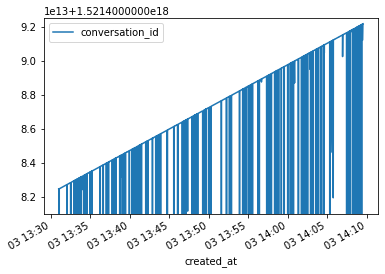

In [33]:
second_df.plot(x='created_at', y='conversation_id', ylim = (1.521481e18, 1.5214925e18))

The full plot shows that people are still responding occasionally to older tweets.

<AxesSubplot:xlabel='created_at'>

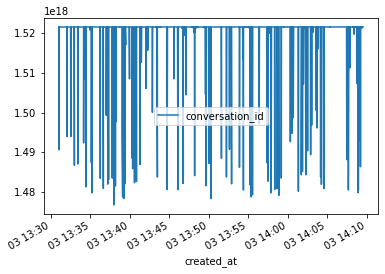

In [35]:
second_df.plot(x='created_at', y='conversation_id', legend=True )

In [40]:
#get date of newest tweet gathered.
# May 4: 6:06 am.
first_df['created_at'].max()

'2022-05-04T06:06:38.000Z'

In [37]:
#get date of oldest tweet gathered.
# May 3, 1:30pm.
second_df['created_at'].min()

Timestamp('2022-05-03 13:31:00+0000', tz='UTC')

I will have to verify the UTC stamp. However, the oldest tweet in any time frame will be the oldest in any other. I can grab the id and search before that to continue a search.

In [42]:
#get the records of the earliest tweets gathered.
second_df[second_df['created_at'] == second_df['created_at'].min()]

,text,author_id,source,possibly_sensitive,context_annotations,lang,created_at,conversation_id,public_metrics,reply_settings,in_reply_to_user_id,referenced_tweets,entities,geo,attachments
id,,,,,,,,,,,,,,,
1521709890603216896,ポケモンWordle 2/10\r\n\r\n⬛🟨⬛⬛⬛\r\n🟩🟩🟩🟩🟩\r\n\r\nh...,484848528,Twitter for iPhone,False,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",ja,2022-05-04T04:34:44.000Z,1521709890603216896,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",everyone,NaN,NaN,"{'urls': [{'start': 30, 'end': 53, 'url': 'htt...",NaN,NaN
1521709890405912576,🤩\r\nWord #124 (🇪🇸 - Clásico) - 4/6\r\n\r\n⬛⬛🟨...,56560715,Twitter for Android,False,"[{'domain': {'id': '30', 'name': 'Entities [En...",es,2022-05-04T04:34:44.000Z,1521709890405912576,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",everyone,NaN,NaN,"{'urls': [{'start': 72, 'end': 95, 'url': 'htt...",NaN,NaN


Glad I didn't index by time. It looks like these were given exactly the same tweet time. Let's verify that one of these `id`s is also the smallest.

In [54]:
second_df.loc[second_df.index[-1]]

text                   🤩\r\nWord #124 (🇪🇸 - Clásico) - 4/6\r\n\r\n⬛⬛🟨...
author_id                                                       56560715
source                                               Twitter for Android
possibly_sensitive                                                 False
context_annotations    [{'domain': {'id': '30', 'name': 'Entities [En...
lang                                                                  es
created_at                                      2022-05-04T04:34:44.000Z
conversation_id                                      1521709890405912576
public_metrics         {'retweet_count': 0, 'reply_count': 0, 'like_c...
reply_settings                                                  everyone
in_reply_to_user_id                                                  NaN
referenced_tweets                                                    NaN
entities               {'urls': [{'start': 72, 'end': 95, 'url': 'htt...
geo                                                

The last index in the list is also the earlist tweet. Great! Just to be extra sure...

In [57]:
#check if the id for the earliest tweet is the same as the smallest id in the index
min(list(second_df.index)) == 1521709890405912576

True

Great. Use that as the `until_id` value in the following search.

### May 4: second big search

perform a few-hours' search-and-save starting from just before the earliest tweet from `tweets_17.csv`.

I'll increase my rate to 20 requests every 15 minutes. This is still less than the 25 for every 15 cap. That's `searches_per_hour = 4`.

Making sure to change the index for the file save to start at `18`, as well as the `until_id` value so I don't just grab the same tweets as before.

In [68]:
%%time
# gather and save for a few hours. 20 requests every 15 minutes.

# be sure to add "+18" (or whatever the last index of csvs is) to
# the priming save, as well as to
# the to_csv() file names at the end

# be sure to set this_until_id to the id of the earliest tweet already gathered.
# not "elegant" or automatic, but getting it done.

#be sure to change searches_per_hour to 4. Also change sleep((60/3)*60)
# to sleep((60/seaches_per_hour)*60)
this_until_id = 1521709890405912576
word_search_tweets, word_search_users, word_search_token = repeat_twitter_search(search_query = '🟩 Wordle',
                                                                                                  tweet_fields = default_tweet_fields,
                                                                                                  user_fields= default_user_fields,
                                                                                                   search_size=100,
                                                                                                   until_id=this_until_id,
                                                                                                   num_searches=20,
                                                                                                   first_next_token='')
word_search_tweets.to_csv(raw_data_path + 'tweets_18.csv')
word_search_users.to_csv(raw_data_path+'users_18.csv')
num_hours = 6
searches_per_hour = 4
for number_search_repeats in range(1, num_hours*searches_per_hour):
    print(f'Waiting for search repeat {number_search_repeats}/{num_hours*searches_per_hour}')
    sleep((60/searches_per_hour)*60) # (60min/3 = 20min )*(secs/min)
    word_search_tweets, word_search_users, word_search_token = repeat_twitter_search(search_query = '🟩 Wordle',
                                                                                                  tweet_fields = default_tweet_fields,
                                                                                                  user_fields= default_user_fields,
                                                                                                   search_size=100,
                                                                                                   until_id=this_until_id,
                                                                                                   num_searches=20,
                                                                                                   first_next_token=word_search_token)
    word_search_tweets.to_csv(raw_data_path + f'tweets_{number_search_repeats + 18}.csv')
    word_search_users.to_csv(raw_data_path + f'users_{number_search_repeats + 18}.csv')

[==========================================================================================..........]
90.0%          18/20
200
Wall time: 5h 50min 39s


This last gather is, unfortunately, largely overlapping the previous one. I didn't have it account for the `until_id`. I have edited that and will run this again.

### May 5: third big search with correct until_id

last one was up to 41. start with 42. chage the priming save as well as +42 to the two to_csv filenames.


In [11]:
%%time
# gather and save for a few hours. 20 requests every 15 minutes.

# be sure to add "+18" (or whatever the last index of csvs is) to
# the priming save, as well as to
# the to_csv() file names at the end

# be sure to set this_until_id to the id of the earliest tweet already gathered.
# not "elegant" or automatic, but getting it done.

#be sure to change searches_per_hour to 4. Also change sleep((60/3)*60)
# to sleep((60/seaches_per_hour)*60)
raw_data_path = '../raw_data/'
this_until_id = 1521709890405912576
word_search_tweets, word_search_users, word_search_token = repeat_twitter_search(search_query = '🟩 Wordle',
                                                                                                  tweet_fields = default_tweet_fields,
                                                                                                  user_fields= default_user_fields,
                                                                                                   search_size=100,
                                                                                                   until_id=this_until_id,
                                                                                                   num_searches=20,
                                                                                                   first_next_token='')
word_search_tweets.to_csv(raw_data_path + 'tweets_42.csv')
word_search_users.to_csv(raw_data_path+'users_42.csv')
num_hours = 10
searches_per_hour = 4
for number_search_repeats in range(1, num_hours*searches_per_hour):
    print(f'Waiting for search repeat {number_search_repeats}/{num_hours*searches_per_hour}')
    sleep((60/searches_per_hour)*60) # (60min/3 = 20min )*(secs/min)
    word_search_tweets, word_search_users, word_search_token = repeat_twitter_search(search_query = '🟩 Wordle',
                                                                                                  tweet_fields = default_tweet_fields,
                                                                                                  user_fields= default_user_fields,
                                                                                                   search_size=100,
                                                                                                   until_id=this_until_id,
                                                                                                   num_searches=20,
                                                                                                   first_next_token=word_search_token)
    word_search_tweets.to_csv(raw_data_path + f'tweets_{number_search_repeats + 42}.csv')
    word_search_users.to_csv(raw_data_path + f'users_{number_search_repeats + 42}.csv')

[==========================================================================================..........]
90.0%          18/20
200
Wall time: 9h 53min 44s


# May 5 fourth big search

This time I need to make sure I start with the right until_id again, as well as the proper csv number. Even witht he change i thought i made, it's not saving the ids correctly. THis is probably for the better -- i'll process them all the same way later.

In [13]:
%%time
# gather and save for a few hours. 20 requests every 15 minutes.

# be sure to add "+18" (or whatever the last index of csvs is) to
# the priming save, as well as to
# the to_csv() file names at the end

# be sure to set this_until_id to the id of the earliest tweet already gathered.
# not "elegant" or automatic, but getting it done.

#be sure to change searches_per_hour to 4. Also change sleep((60/3)*60)
# to sleep((60/seaches_per_hour)*60)
raw_data_path = '../raw_data/'
this_until_id = 1521174856938708997
word_search_tweets, word_search_users, word_search_token = repeat_twitter_search(search_query = '🟩 Wordle',
                                                                                                  tweet_fields = default_tweet_fields,
                                                                                                  user_fields= default_user_fields,
                                                                                                   search_size=100,
                                                                                                   until_id=this_until_id,
                                                                                                   num_searches=20,
                                                                                                   first_next_token='')
word_search_tweets.to_csv(raw_data_path + 'tweets_82.csv')
word_search_users.to_csv(raw_data_path+'users_82.csv')
num_hours = 10
searches_per_hour = 4
for number_search_repeats in range(1, num_hours*searches_per_hour):
    print(f'Waiting for search repeat {number_search_repeats}/{num_hours*searches_per_hour}')
    sleep((60/searches_per_hour)*60) # (60min/3 = 20min )*(secs/min)
    word_search_tweets, word_search_users, word_search_token = repeat_twitter_search(search_query = '🟩 Wordle',
                                                                                                  tweet_fields = default_tweet_fields,
                                                                                                  user_fields= default_user_fields,
                                                                                                   search_size=100,
                                                                                                   until_id=this_until_id,
                                                                                                   num_searches=20,
                                                                                                   first_next_token=word_search_token)
    word_search_tweets.to_csv(raw_data_path + f'tweets_{number_search_repeats + 82}.csv')
    word_search_users.to_csv(raw_data_path + f'users_{number_search_repeats + 82}.csv')

[==========================================================================================..........]
90.0%          18/20
200
Wall time: 9h 54min 20s


# May 6 search

In [8]:
%%time
# gather and save for a few hours. 20 requests every 15 minutes.

# be sure to add "+18" (or whatever the last index of csvs is) to
# the priming save, as well as to
# the to_csv() file names at the end

# be sure to set this_until_id to the id of the earliest tweet already gathered.
# not "elegant" or automatic, but getting it done.

#be sure to change searches_per_hour to 4. Also change sleep((60/3)*60)
# to sleep((60/seaches_per_hour)*60)
raw_data_path = '../raw_data/'
this_until_id = 1520733408237916161
word_search_tweets, word_search_users, word_search_token = repeat_twitter_search(search_query = '🟩 Wordle',
                                                                                                  tweet_fields = default_tweet_fields,
                                                                                                  user_fields= default_user_fields,
                                                                                                   search_size=100,
                                                                                                   until_id=this_until_id,
                                                                                                   num_searches=20,
                                                                                                   first_next_token='')
word_search_tweets.to_csv(raw_data_path + f'tweets_122.csv')
word_search_users.to_csv(raw_data_path+'users_122.csv')
num_hours = 9
searches_per_hour = 4
for number_search_repeats in range(1, num_hours*searches_per_hour):
    print(f'Waiting for search repeat {number_search_repeats}/{num_hours*searches_per_hour}')
    sleep((60/searches_per_hour)*60) # (60min/3 = 20min )*(secs/min)
    word_search_tweets, word_search_users, word_search_token = repeat_twitter_search(search_query = '🟩 Wordle',
                                                                                                  tweet_fields = default_tweet_fields,
                                                                                                  user_fields= default_user_fields,
                                                                                                   search_size=100,
                                                                                                   until_id=this_until_id,
                                                                                                   num_searches=20,
                                                                                                   first_next_token=word_search_token)
    word_search_tweets.to_csv(raw_data_path + f'tweets_{number_search_repeats + 122}.csv')
    word_search_users.to_csv(raw_data_path + f'users_{number_search_repeats + 122}.csv')

[==========================================================================================..........]
90.0%          18/20
200
Wall time: 8h 53min


# May 6 search number two

as usual, set the csv numbers appropriately and set the oldest already-gathered tweet id before running.

the last tweet id in `tweets_157.csv` is 1520206923991519232.
start saving with tweets 158.

In [10]:
%%time
# gather and save for a few hours. 20 requests every 15 minutes.

# be sure to add "+18" (or whatever the last index of csvs is) to
# the priming save, as well as to
# the to_csv() file names at the end

# be sure to set this_until_id to the id of the earliest tweet already gathered.
# not "elegant" or automatic, but getting it done.

#be sure to change searches_per_hour to 4. Also change sleep((60/3)*60)
# to sleep((60/seaches_per_hour)*60)
raw_data_path = '../raw_data/'
this_until_id = 1520206923991519232
word_search_tweets, word_search_users, word_search_token = repeat_twitter_search(search_query = '🟩 Wordle',
                                                                                                  tweet_fields = default_tweet_fields,
                                                                                                  user_fields= default_user_fields,
                                                                                                   search_size=100,
                                                                                                   until_id=this_until_id,
                                                                                                   num_searches=20,
                                                                                                   first_next_token='')
word_search_tweets.to_csv(raw_data_path + f'tweets_158.csv')
word_search_users.to_csv(raw_data_path+'users_158.csv')
num_hours = 9
searches_per_hour = 4
for number_search_repeats in range(1, num_hours*searches_per_hour):
    print(f'Waiting for search repeat {number_search_repeats}/{num_hours*searches_per_hour}')
    sleep((60/searches_per_hour)*60) # (60min/3 = 20min )*(secs/min)
    word_search_tweets, word_search_users, word_search_token = repeat_twitter_search(search_query = '🟩 Wordle',
                                                                                                  tweet_fields = default_tweet_fields,
                                                                                                  user_fields= default_user_fields,
                                                                                                   search_size=100,
                                                                                                   until_id=this_until_id,
                                                                                                   num_searches=20,
                                                                                                   first_next_token=word_search_token)
    word_search_tweets.to_csv(raw_data_path + f'tweets_{number_search_repeats + 158}.csv')
    word_search_users.to_csv(raw_data_path + f'users_{number_search_repeats + 158}.csv')

[=================================================================...................................]
65.0%          13/20
200


KeyError: 'next_token'

There was no next_token at the end of this. I suspect I reached a full week back, and was unable to gather any older tweets. This is great! I had only reached ~350,000 gathered tweets total in my Twitter developer project up to here. I can continue gathering tweets for the next few days.

This will require some changes to the gathering function --- instead of setting `until_id`, I will need to set a `since_id` instead.

---
# May 10 search --- filling missing tweets from 
searching through tweets up to the end of may 5th that haven't been gathered yet.

Be sure to set the four csv numbers appropriately. They just have to be distinct, not chronological. They will be sorted by tweet id ahead.

remove until_id from the two repeat_twitter_search calls, and add in `since_id` and `end_time`.

In [8]:
%%time
# gather and save for a few hours. 20 requests every 15 minutes.

# be sure to add "+18" (or whatever the last index of csvs is) to
# the priming save, as well as to
# the to_csv() file names at the end

# be sure to set this_until_id to the id of the earliest tweet already gathered.
# not "elegant" or automatic, but getting it done.

#be sure to change searches_per_hour to 4. Also change sleep((60/3)*60)
# to sleep((60/seaches_per_hour)*60)
raw_data_path = '../raw_data/'
#this_since_id = 1521911830817521664
this_end_time = '2022-05-05T21:59:59.00z'
word_search_tweets, word_search_users, word_search_token = repeat_twitter_search(search_query = '🟩 Wordle',
                                                                                                  tweet_fields = default_tweet_fields,
                                                                                                  user_fields= default_user_fields,
                                                                                                   search_size=100,
                                                                                                    end_time=this_end_time,
                                                                                                   num_searches=20,
                                                                                                   first_next_token='')
word_search_tweets.to_csv(raw_data_path + f'tweets_162.csv')
word_search_users.to_csv(raw_data_path+'users_162.csv')
num_hours = 9
searches_per_hour = 4
for number_search_repeats in range(1, num_hours*searches_per_hour):
    print(f'Waiting for search repeat {number_search_repeats}/{num_hours*searches_per_hour}')
    sleep((60/searches_per_hour)*60) # (60min/3 = 20min )*(secs/min)
    word_search_tweets, word_search_users, word_search_token = repeat_twitter_search(search_query = '🟩 Wordle',
                                                                                                  tweet_fields = default_tweet_fields,
                                                                                                  user_fields= default_user_fields,
                                                                                                   search_size=100,
                                                                                                    end_time = this_end_time,
                                                                                                   num_searches=20,
                                                                                                   first_next_token=word_search_token)
    word_search_tweets.to_csv(raw_data_path + f'tweets_{number_search_repeats + 162}.csv')
    word_search_users.to_csv(raw_data_path + f'users_{number_search_repeats + 162}.csv')

[===============================================================================================......]
94.73684210526316%          18/19
200
Waiting for search repeat 32/36


ConnectionError: HTTPSConnectionPool(host='api.twitter.com', port=443): Max retries exceeded with url: /2/tweets/search/recent?query=%F0%9F%9F%A9%20Wordle&tweet.fields=attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,id,in_reply_to_user_id,lang,public_metrics,possibly_sensitive,referenced_tweets,reply_settings,source,text,withheld&user.fields=description,entities,id,location,name,pinned_tweet_id,profile_image_url,protected,public_metrics,url,username,verified,withheld&max_results=100&end_time=2022-05-05T21:59:59.00z&expansions=author_id&next_token=b26v89c19zqg8o3fpywl8365qc4clat5sc7w5ba95jkal (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000018D447F2C10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

---
# May 11 search --- using `since_id` and `until_id`
searching through tweets up to the end of may 5th that haven't been gathered yet.

Be sure to set the four csv numbers appropriately. They just have to be distinct, not chronological. They will be sorted by tweet id ahead.


mixing id-relative and time-relative search seems to get twitter upset. Just using since-id and until_id

The first missing value in the stretch is at May 4, 17:58:00
the last missing value is at May 4, 23:26:00.

The id of the tweet just before the first missing value is 1521911830817521664
The id of the tweet just after the last missing value is 1521994876677672966

max csv number is currently 193, set the four values below to 194.


In [14]:
%%time
# gather and save for a few hours. 20 requests every 15 minutes.

# be sure to add "+18" (or whatever the last index of csvs is) to
# the priming save, as well as to
# the to_csv() file names at the end

# be sure to set this_until_id to the id of the earliest tweet already gathered.
# not "elegant" or automatic, but getting it done.

#be sure to change searches_per_hour to 4. Also change sleep((60/3)*60)
# to sleep((60/seaches_per_hour)*60)
raw_data_path = '../raw_data/'
this_since_id = 1521924000000000000
this_until_id = 1521994876677672966
word_search_tweets, word_search_users, word_search_token = repeat_twitter_search(search_query = '🟩 Wordle',
                                                                                                  tweet_fields = default_tweet_fields,
                                                                                                  user_fields= default_user_fields,
                                                                                                   search_size=100,
                                                                                                   until_id = this_until_id,
                                                                                                 since_id = this_since_id,
                                                                                                   num_searches=20,
                                                                                                   first_next_token='')
word_search_tweets.to_csv(raw_data_path + f'tweets_194.csv')
word_search_users.to_csv(raw_data_path+'users_194.csv')
num_hours = 9
searches_per_hour = 4
for number_search_repeats in range(1, num_hours*searches_per_hour):
    print(f'Waiting for search repeat {number_search_repeats}/{num_hours*searches_per_hour}')
    sleep((60/searches_per_hour)*60) # (60min/3 = 20min )*(secs/min)
    word_search_tweets, word_search_users, word_search_token = repeat_twitter_search(search_query = '🟩 Wordle',
                                                                                                  tweet_fields = default_tweet_fields,
                                                                                                  user_fields= default_user_fields,
                                                                                                   search_size=100,
                                                                                                   until_id = this_until_id,
                                                                                                 since_id = this_since_id,
                                                                                                   num_searches=20,
                                                                                                   first_next_token=word_search_token)
    word_search_tweets.to_csv(raw_data_path + f'tweets_{number_search_repeats + 194}.csv')
    word_search_users.to_csv(raw_data_path + f'users_{number_search_repeats + 194}.csv')

[===============================================================================================......]
94.73684210526316%          18/19
200
Waiting for search repeat 1/36
400


Exception: (400, '{"errors":[{"parameters":{"since_id":["1521924000000000000"]},"message":"\'since_id\' must be a tweet id created after 2022-05-04T18:57Z. Please use a \'since_id\' that is larger than 1521927031850270720"}],"title":"Invalid Request","detail":"One or more parameters to your request was invalid.","type":"https://api.twitter.com/2/problems/invalid-request"}')